In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as dist
from torch.distributions import MultivariateNormal

import matplotlib.pyplot as plt
import seaborn as sns

# Set the random seed
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

Device: cpu


In [2]:
def generate_gaussian_data(n_samples, mean, cov):    
    
    return MultivariateNormal(mean, cov).sample((n_samples,))


## 1 Une distrib contre une autre

In [66]:
dim = 2

mean_1 = torch.tensor([0.0, 0.0])
mean_2  = torch.tensor([0.5, 0.25])
cov_1 = torch.tensor([[1.0, 0.5], [0.5, 2.0]])
cov_2 = torch.tensor([[1.5, -0.5], [-0.5, 1.5]])

In [106]:
class Critic(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers):
        super(Critic, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.fc1 = nn.Linear(self.input_dim, self.hidden_dim)

        self.layers = nn.ModuleList([nn.Linear(self.hidden_dim, self.hidden_dim) for _ in range(n_layers - 2)])

        self.fc2 = nn.Linear(self.hidden_dim, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        for layer in self.layers:
            x = self.relu(layer(x))
        x = self.fc2(x)
        return x

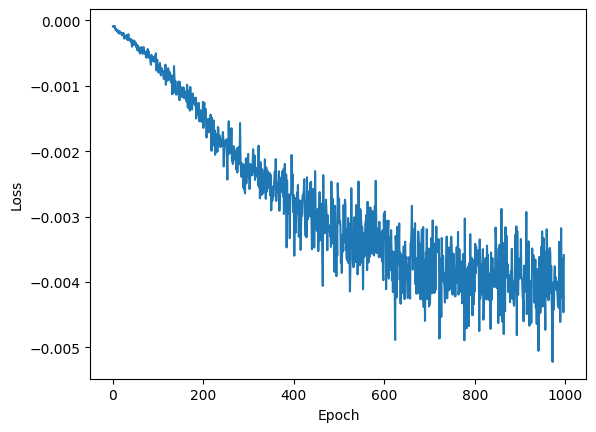

In [112]:
# Hyperparameters
input_dim = dim
hidden_dim = 128
n_layers = 3
batch_size = 512
n_epochs = 1000
lr = 5e-5
clip_value = 0.01

critic = Critic(input_dim, hidden_dim, n_layers)
optimizer_C = optim.RMSprop(critic.parameters(), lr=lr)

critic_losses = []
for epoch in range(n_epochs):

    # Sample data from both distributions
    samples_1 = generate_gaussian_data(batch_size, mean_1, cov_1)
    samples_2 = generate_gaussian_data(batch_size, mean_2, cov_2)

    # Train the critic
    optimizer_C.zero_grad()
    critic_1 = torch.mean(critic(samples_1))
    critic_2 = torch.mean(critic(samples_2))
    critic_loss = critic_1 - critic_2
    critic_losses.append(critic_loss.item())
    critic_loss.backward()
    optimizer_C.step()

    # Clip critic's weights
    for p in critic.parameters():
        p.data.clamp_(-clip_value, clip_value)

    # Print progress
    # if epoch % 10 == 0:
    #     print(f"Epoch {epoch}/{n_epochs}: Critic Loss: {critic_loss.item()}")

# Plot loss
plt.plot(critic_losses[2:])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [113]:
# Sample data from both distributions
samples_1 = generate_gaussian_data(10000, mean_1, cov_1)
samples_2 = generate_gaussian_data(10000, mean_2, cov_2)

# Compute the critic's output
critic_1 = critic(samples_1)
critic_2 = critic(samples_2)
W1_estimated = (torch.mean(critic_2) - torch.mean(critic_1)).item()
W1_estimated

0.0040841070003807545

In [114]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal

def sinkhorn_algorithm(mu, nu, C, reg, max_iters=1000, tol=1e-9):
    K = np.exp(-C / reg)
    u = np.ones_like(mu)
    v = np.ones_like(nu)

    for _ in range(max_iters):
        u_prev = u.copy()
        v = nu / (K.T @ u)
        u = mu / (K @ v)
        
        if np.linalg.norm(u - u_prev) < tol:
            break

    return u, v

def sinkhorn_distance_normalized(mu, nu, X, Y, reg, p=1, max_iters=1000, tol=1e-9):
    C = cdist(X, Y, metric='minkowski', p=p)
    C = C / np.max(C)  # Normalize the cost matrix
    u, v = sinkhorn_algorithm(mu, nu, C, reg, max_iters, tol)
    K = np.exp(-C / reg)
    return np.sum(u * (C @ v))

def sample_gaussian(mean, cov, num_samples):
    return np.random.multivariate_normal(mean, cov, num_samples)

def discretize_gaussian(mean, cov, num_samples):
    samples = sample_gaussian(mean, cov, num_samples)
    weights = np.full(num_samples, 1 / num_samples)
    return weights, samples

# Number of samples and regularization parameter
num_samples = 5_000
reg = 10

# Discretize the Gaussian distributions
mu, X = discretize_gaussian(mean_1, cov_1, num_samples)
nu, Y = discretize_gaussian(mean_2, cov_2, num_samples)

# Compute Wasserstein-1 distance
w1_distance = sinkhorn_distance_normalized(mu, nu, X, Y, reg)
print("Wasserstein-1 distance between Gaussian distributions:", w1_distance)

Wasserstein-1 distance between Gaussian distributions: 0.21030638522284184


## 2 des distrib gaussiennes un peu aléatoires